In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/NLP/Malicious Link Detection')
!ls

malicious_phish.csv  Untitled0.ipynb


In [3]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment',None)

from urllib.parse import urlparse, parse_qs
import re
import ipaddress
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

In [6]:
malicious_data = pd.read_csv('malicious_phish.csv')

In [7]:
malicious_data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [8]:
malicious_data['type'].value_counts()

,count
type,
benign,428103
defacement,96457
phishing,94111
malware,32520


In [9]:
malicious_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [10]:
type_mapping = {
    'malware' : 3,
    'defacement':2,
    'phishing':1,
    'benign':0
}

malicious_data['type'] = malicious_data['type'].map(type_mapping)
malicious_data

,url,type
0,br-icloud.com.br,1
1,mp3raid.com/music/krizz_kaliko.html,0
2,bopsecrets.org/rexroth/cr/1.htm,0
3,http://www.garage-pirenne.be/index.php?option=...,2
4,http://adventure-nicaragua.net/index.php?optio...,2
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1
651188,www.gamespot.com/xbox360/action/deadspace/,1
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1


In [11]:
def get_url_len(url):
  return len(url)


get_url_len('mp3raid.com/music/krizz_kaliko.html')

35

In [12]:
malicious_data['url_length'] = malicious_data['url'].str.len()

malicious_data.head()

,url,type,url_length
0,br-icloud.com.br,1,16
1,mp3raid.com/music/krizz_kaliko.html,0,35
2,bopsecrets.org/rexroth/cr/1.htm,0,31
3,http://www.garage-pirenne.be/index.php?option=...,2,88
4,http://adventure-nicaragua.net/index.php?optio...,2,235


In [13]:
def extract_domain_length(url):
  try:
    if not url.startswith(('http://', 'https://')):
      url = 'http://' + url
    parsed_url = urlparse(url)
    domain = parsed_url.netloc
    return len(domain) if domain else 0
  except Exception as e:
    return 0

extract_domain_length('br-icloud.com.br')

16

In [14]:
malicious_data['domain_length'] = malicious_data['url'].apply(extract_domain_length)

In [15]:
malicious_data = malicious_data[malicious_data['domain_length'] != 0]

malicious_data[malicious_data['domain_length']==0]

,url,type,url_length,domain_length


In [16]:
def check_http(url):
  if url.startswith('http://'):
    return 1
  else:
    return 0

check_http('http://www.garage-pirenne.be/index.php?option')

1

In [17]:
malicious_data.loc[:,'check_http'] = malicious_data['url'].apply(check_http)

malicious_data.head()

,url,type,url_length,domain_length,check_http
0,br-icloud.com.br,1,16,16,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1


In [111]:
def check_https(url):
  if url.startswith('https://'):
    return 1
  else:
    return 0

check_https('http://www.garage-pirenne.be/index.php?option')

0

In [112]:
malicious_data.loc[:,'check_https'] = malicious_data['url'].apply(check_http)

malicious_data[malicious_data['check_https'] == 1]

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
40,https://docs.google.com/spreadsheet/viewform?f...,1,87,15,0,1,2,0,0,1,4,9,5,73,0,1,0,0,0,0
129,https://twitter.com/home?status=%E3%83%8C%E3%8...,0,290,11,0,1,2,1,0,1,3,82,90,118,0,1,0,0,0,0
491,https://medium.com/human-parts/the-laziest-com...,0,113,10,0,1,1,11,0,1,4,19,6,88,0,1,0,0,0,0
772,https://hollywoodlife.com/2015/05/14/new-york-...,0,108,17,0,1,1,10,0,0,7,19,9,80,0,0,0,0,0,0
1102,https://paytm.com/blog/vijay-shekahr-sharma-on...,0,100,9,0,1,1,8,0,1,5,17,0,83,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555094,https://drive.google.com/uc?export=download&id...,3,80,16,0,1,2,1,0,1,3,11,2,67,0,2,0,0,0,0
555118,https://onedrive.live.com/download?cid=9BEF332...,3,108,17,0,1,2,0,0,1,3,13,22,73,0,3,0,0,0,0
555119,https://onedrive.live.com/download?cid=DD0A0EC...,3,109,17,0,1,2,0,1,1,3,13,20,75,0,3,0,0,0,0
555120,https://onedrive.live.com/download?cid=CF0C6D1...,3,108,17,0,1,2,0,0,1,3,13,25,70,0,3,0,0,0,0


In [113]:
def count_dots(url):
  return url.count('.')

In [114]:
malicious_data['dot_count'] = malicious_data['url'].apply(count_dots)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [115]:
def count_dashes(url):
  return url.count('-')

In [116]:
malicious_data['dash_count'] = malicious_data['url'].apply(count_dashes)

malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [117]:
def count_underscores(url):
  return url.count('_')

In [118]:
malicious_data['underscore_count'] = malicious_data['url'].apply(count_underscores)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [119]:
def count_ques(url):
  return url.count('?')

In [120]:
malicious_data['ques_count'] = malicious_data['url'].apply(count_ques)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [121]:
def count_slashes(url):
    return url.count('/')

In [122]:
malicious_data['slash_count'] = malicious_data['url'].apply(count_slashes)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [123]:
def count_special_chars(url):
  non_alpha_num = re.findall(r'\W',url)
  return len(non_alpha_num)

In [124]:
malicious_data['special_chars_count'] = malicious_data['url'].apply(count_special_chars)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [125]:
def count_digits(url):
  digits = re.findall(r'\d',url)
  return len(digits)

In [126]:
malicious_data['digits_count'] = malicious_data['url'].apply(count_digits)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [127]:
def count_letters(url):
  letters = re.findall(r'[a-zA-Z]',url)
  return len(letters)

In [128]:
malicious_data['letters_count'] = malicious_data['url'].apply(count_letters)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [129]:
def has_ip_address(url):
  try:
    parsed_url = urlparse(url)
    if parsed_url.hostname:
      ip = ipaddress.ip_address(parsed_url.hostname)
      return isinstance(ip,(ipaddress.IPv4Address,ipaddress.IPv6Address))
  except ValueError:
      pass
  return 0

has_ip_address('Google.com')

0

In [130]:
malicious_data['has_ip'] = malicious_data['url'].apply(has_ip_address)
malicious_data['has_ip'] = malicious_data['has_ip'].astype(int)
malicious_data['has_ip'].info()

<class 'pandas.core.series.Series'>
Index: 651173 entries, 0 to 651190
Series name: has_ip
Non-Null Count   Dtype
--------------   -----
651173 non-null  int64
dtypes: int64(1)
memory usage: 9.9 MB


In [131]:
def count_url_parameters(url):
  parsed_url = urlparse(url)
  query = parsed_url.query

  parameters = parse_qs(query)

  return len(parameters)

In [132]:
malicious_data['param_count'] = malicious_data['url'].apply(count_url_parameters)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [133]:
def check_php_in_url(url):
  if 'php' in url.lower():
    return 1
  else:
    return 0

In [134]:
malicious_data['has_php'] = malicious_data['url'].apply(check_php_in_url)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [135]:
def check_html_in_url(url):
  if 'html' in url.lower():
    return 1
  else:
    return 0

In [136]:
malicious_data['has_html'] = malicious_data['url'].apply(check_html_in_url)
malicious_data

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0
1,mp3raid.com/music/krizz_kaliko.html,0,35,11,0,0,2,0,1,0,2,4,1,29,0,0,0,1,0,0
2,bopsecrets.org/rexroth/cr/1.htm,0,31,14,0,0,2,0,0,0,3,5,1,25,0,0,0,0,0,0
3,http://www.garage-pirenne.be/index.php?option=...,2,88,21,1,0,3,1,2,1,3,16,7,63,0,4,1,0,0,0
4,http://adventure-nicaragua.net/index.php?optio...,2,235,23,1,0,2,1,1,1,3,13,22,199,0,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,1,39,15,0,0,3,0,0,0,3,6,12,21,0,0,0,1,0,0
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,1,44,18,0,0,2,2,0,0,4,8,7,29,0,0,0,0,0,0
651188,www.gamespot.com/xbox360/action/deadspace/,1,42,16,0,0,2,0,0,0,4,6,3,33,0,0,0,0,0,0
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),1,45,16,0,0,2,0,3,0,2,6,0,36,0,0,0,0,0,0


In [137]:
tld_list = [
    '.tk', '.buzz', '.xyz', '.top', '.ga', '.ml', '.info', '.cf', '.gq', '.icu', '.wang', '.live', '.host', '.shop' , '.top', '.icu', '.vip', '.id', '.cc', '.br', '.ci', '.zw', '.sx', '.mw'
]

In [138]:
def check_mal_tld(url):
  parsed_url = urlparse(url)
  netloc = parsed_url.netloc.lower()

  if any(netloc.endswith(tld) for tld in tld_list):
    return 1
  return 0


url = 'http://example.xyz/path'

print(check_mal_tld(url))

1


In [139]:
malicious_data['mal_tld'] = malicious_data['url'].apply(check_mal_tld)
malicious_data[malicious_data['mal_tld'] == 1]

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
60,http://www.approvi.com.br/ck.htm,2,32,18,1,0,4,0,0,0,3,8,0,24,0,0,0,0,1,0
65,http://www.juventudelirica.com.br/index.html,2,44,26,1,0,4,0,0,0,3,8,0,36,0,0,0,1,1,0
99,http://www.viamanaus.com.br/index.php?option=c...,2,80,20,1,0,4,0,1,1,3,14,3,62,0,3,1,0,1,0
115,http://9779.info/%E5%84%BF%E7%AB%A5%E7%AB%8B%E...,3,81,9,1,0,1,0,0,0,4,27,22,32,0,0,0,0,1,0
130,http://correios.com.br/para-sua-empresa/comuni...,0,136,15,1,0,2,10,0,0,7,20,1,115,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553939,http://fb-recovery-10000076733-it.tk/update_se...,3,56,29,1,0,2,3,1,0,3,9,11,35,0,0,0,0,1,0
554279,http://chatmusic.xyz/a3b87a035d656b088bf84f818...,3,60,13,1,0,2,0,0,0,4,7,22,31,0,0,0,0,1,0
554280,http://castmart.ga/~zadmin/icloud/gold_encrypt...,3,60,11,1,0,2,0,2,0,5,9,6,43,0,0,0,0,1,0
554998,http://tokyomangass.host/ticket.exe,3,35,17,1,0,2,0,0,0,3,6,0,29,0,0,0,0,1,0


In [140]:
def is_shortened_url(url):
  shortened_services = [
      "bit.ly", "tinyurl.com", "goo.gl", "t.co", "ow.ly", "buff.ly",
        "is.gd", "adf.ly", "bit.do", "cutt.ly", "v.gd", "shorte.st",
        "bl.ink", "x.co", "s.id", "trib.al"
  ]

  parsed_url = urlparse(url)
  netloc = parsed_url.netloc.lower()

  if any(service in netloc for service in shortened_services):
    return 1
  return 0


url = 'https://bit.ly/3abcxyz'
print(is_shortened_url(url))


1


In [141]:
malicious_data['shortened'] = malicious_data['url'].apply(is_shortened_url)
malicious_data[malicious_data['shortened'] == 1]

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
28,http://www.marketingbyinternet.com/mo/e56508df...,1,71,27,1,0,2,0,0,0,5,8,17,46,0,0,0,0,0,1
98,http://serverfault.com/questions/682832/squid-...,0,107,15,1,0,1,9,0,0,5,16,6,85,0,0,0,0,0,1
146,http://www.tiendagnulinux.com.ar/calcomanias-e...,2,86,25,1,0,4,2,1,1,3,14,2,69,0,2,0,0,0,1
160,http://mylust.com/videos/232790/hentai-slut-wi...,0,88,10,1,0,1,9,0,0,6,17,6,65,0,0,0,0,0,1
333,http://yourlust.com/videos/tight-euro-teen-ann...,0,86,12,1,0,2,9,0,0,4,16,0,70,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554075,http://gmmfuelassist.co.uk/sport/37yas27.exe,3,44,19,1,0,3,0,0,0,4,8,4,32,0,0,0,0,0,1
554076,http://gmmfuelassist.co.uk/sport/28yas27.exe,3,44,19,1,0,3,0,0,0,4,8,4,32,0,0,0,0,0,1
554077,http://gmmfuelassist.co.uk/sport/448yas27.exe,3,45,19,1,0,3,0,0,0,4,8,5,32,0,0,0,0,0,1
554078,https://gmmfuelassist.co.uk/sport/rockstar.php,3,46,19,0,1,3,0,0,0,4,8,0,38,0,0,1,0,0,1


In [142]:
malx = malicious_data.drop(columns = {'type','url'})

In [143]:
x_train = malx.iloc[:,:].values

print(x_train)
print(x_train.shape)

[[16 16  0 ...  0  0  0]
 [35 11  0 ...  1  0  0]
 [31 14  0 ...  0  0  0]
 ...
 [42 16  0 ...  0  0  0]
 [45 16  0 ...  0  0  0]
 [41 17  0 ...  0  0  0]]
(651173, 18)


In [144]:
y_train = np.array(malicious_data['type'])

y_train = y_train.reshape(-1,1)

print(y_train)
print(y_train.shape[0])

[[1]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
651173


In [145]:
model = Sequential([
    Dense(units = 13, activation = 'relu', name = 'layer_1'),
    Dense(units = 4, activation = 'linear', name = 'softmax_output')
])

In [146]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics=['accuracy'])

In [147]:
history = model.fit(x_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9065 - loss: 0.7296 - val_accuracy: 0.3935 - val_loss: 3.4858
Epoch 2/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 48s 3ms/step - accuracy: 0.9556 - loss: 0.1365 - val_accuracy: 0.3777 - val_loss: 3.5521
Epoch 3/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 80s 3ms/step - accuracy: 0.9579 - loss: 0.1295 - val_accuracy: 0.4012 - val_loss: 3.5559
Epoch 4/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.9582 - loss: 0.1268 - val_accuracy: 0.4201 - val_loss: 3.6887
Epoch 5/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 85s 3ms/step - accuracy: 0.9607 - loss: 0.1205 - val_accuracy: 0.4039 - val_loss: 3.7978
Epoch 6/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - accuracy: 0.9620 - loss: 0.1165 - val_accuracy: 0.4126 - val_loss: 3.6584
Epoch 7/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9637 - loss: 0.1124 - val_accuracy: 0.4149 - val_loss: 3.7294
Epoch 8/10
16280/16280 ━━━━━━━━━━━━━━━━━━━━ 83s 3ms/step - accuracy: 

In [148]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ layer_1 (Dense)                      │ (None, 13)                  │             247 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_output (Dense)               │ (None, 4)                   │              56 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 911 (3.56 KB)

 Trainable params: 303 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 608 (2.38 KB)

In [149]:
train_loss,train_acc = model.evaluate(x_train,y_train)

print(f'Training accuracy: {train_acc} with training loss of: {train_loss}')

20350/20350 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.9570 - loss: 0.1533
Training accuracy: 0.8596010804176331 with training loss of: 0.9224156141281128


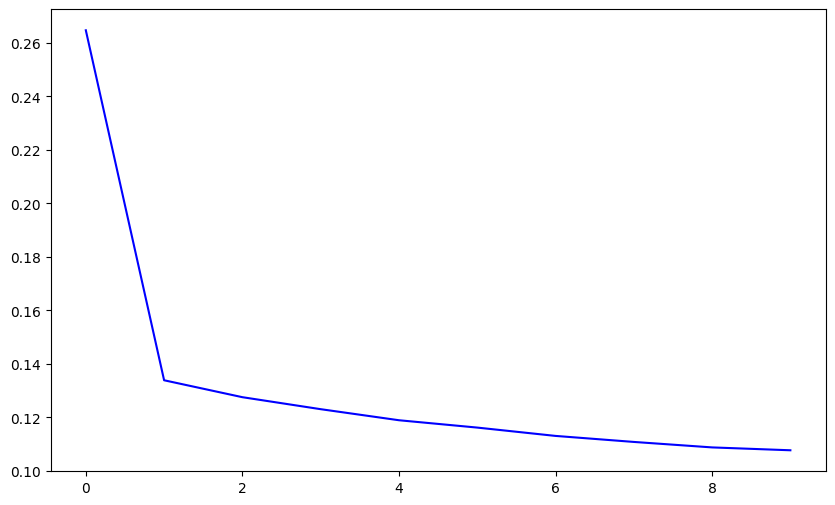

In [150]:
train_loss = history.history['loss']

epoch = np.arange(len(train_loss))

plt.figure(figsize=(10, 6))
plt.plot(epoch, train_loss, label='Training Loss', color='blue')

In [151]:
malicious_data.head(1)

,url,type,url_length,domain_length,check_http,check_https,dot_count,dash_count,underscore_count,ques_count,slash_count,special_chars_count,digits_count,letters_count,has_ip,param_count,has_php,has_html,mal_tld,shortened
0,br-icloud.com.br,1,16,16,0,0,2,1,0,0,0,3,0,13,0,0,0,0,0,0


In [152]:
x_train[0]

array([16, 16,  0,  0,  2,  1,  0,  0,  0,  3,  0, 13,  0,  0,  0,  0,  0,
        0])

In [153]:
def prepare_input(url):
    features = []

    feature_extractors = [
        get_url_len,
        extract_domain_length,
        check_http,
        check_https,
        count_dots,
        count_dashes,
        count_underscores,
        count_ques,
        count_slashes,
        count_special_chars,
        count_digits,
        count_letters,
        has_ip_address,
        count_url_parameters,
        check_php_in_url,
        check_html_in_url,
        check_mal_tld,
        is_shortened_url
    ]

    for feature_extractor in feature_extractors:
        features.append(feature_extractor(url))

    x_test = np.array(features).reshape(1, -1)

    return x_test

prepare_input('br-icloud.com.br')

array([[16, 16,  0,  0,  2,  1,  0,  0,  0,  3,  0, 13,  0,  0,  0,  0,
         0,  0]])

In [154]:
def predict(url):
    x_test = prepare_input(url)
    predictions = model.predict(x_test)
    predicted_class = np.argmax(predictions, axis=1)
    print(f'the link is of type {predicted_class}')

predict('http://www.824555.com/app/member/SportOption.p')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
the link is of type [0]
